In [2]:
!rm -d -r wikiauto
!git clone https://github.com/tomm2000/wikiauto

device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/wikiauto/')

In [ ]:
from __future__ import unicode_literals, print_function, division
from vocab import vocab, END_TOKEN, START_TOKEN, PADDING_TOKEN, UNKNOWN_TOKEN
from helpers import readLines
from load_data import load_data_evaluate, load_data_training, getInputSizeAverage
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import json

ENCODER_INPUT_SIZE = 20
DECODER_OUTPUT_SIZE = 75
BATCH_SIZE = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

base_path = "/content/drive/MyDrive/ColabData/"
# device = "cpu"

In [3]:
# from load_data import getInputSizeAverage

# print(getInputSizeAverage())

# ENCODER

In [4]:
class EncoderRNN(nn.Module):
  def __init__(self, type_vocab, value_vocab, hidden_size, embedding_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.typeEmbedding = nn.Embedding(len(type_vocab), embedding_size, device=device)
    self.valueEmbedding = nn.Embedding(len(value_vocab), embedding_size, device=device)
    self.positionEmbedding = nn.Embedding(ENCODER_INPUT_SIZE, 10, device=device)
    
    self.gru = nn.GRU(embedding_size * 2 + 10, self.hidden_size)

  def forward(self, inputs, hidden):
    E_type_out = self.typeEmbedding(inputs[0])
    E_value_out = self.valueEmbedding(inputs[1])
    E_pos_out = self.positionEmbedding(inputs[2])

    output = torch.cat((E_type_out, E_pos_out, E_value_out), dim=1).view(1, BATCH_SIZE, -1)

    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)

# ATTENTION DECODER

In [5]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_vocab_size, dropout_p=0.1):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_vocab_size = output_vocab_size
    self.dropout_p = dropout_p

    self.embedding = nn.Embedding(self.output_vocab_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size * 2, ENCODER_INPUT_SIZE)
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_vocab_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, BATCH_SIZE, -1)
    embedded = self.dropout(embedded)

    attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

    attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)

    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

# TIMING & PLOT

In [6]:
import time
import math
import datetime

def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)


def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.01)
  ax.yaxis.set_major_locator(loc)
  # ax.set_facecolor('pink')
  plt.plot(points)
  plt.show()

def getPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.01)
  ax.yaxis.set_major_locator(loc)
  # ax.set_facecolor('pink')
  plt.plot(points)
  return fig

# INPUT

In [7]:
type_vocab, value_vocab, token_vocab, pairs = load_data_training(
  torch=torch,
  device=device,
  vocab_size=50000,
  batch_size=BATCH_SIZE,
  input_size=ENCODER_INPUT_SIZE,
  output_size=DECODER_OUTPUT_SIZE,
  pair_amount=1000000/BATCH_SIZE,
  path=base_path
)

too many pairs requested, new pair amount (articles / batch_size):  78523
------------------------
loading data: 7853/78523 (10%)
loading data: 15706/78523 (20%)
loading data: 23559/78523 (30%)
loading data: 31412/78523 (40%)
loading data: 39265/78523 (50%)
loading data: 47118/78523 (60%)
loading data: 54971/78523 (70%)
loading data: 62824/78523 (80%)
loading data: 70677/78523 (90%)
------------------------
pairs: 78496, total articles: 392480
batch size: 5, input size: 20, output size: 75
input shape:  torch.Size([3, 5, 20])
output shape:  torch.Size([5, 75])


# TRAINING

In [8]:
teacher_forcing_ratio = 0.5

# NOTE: inputs are (1, BATCH_SIZE)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  encoder_hidden = encoder.initHidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(2) # == PHRASE_SIZE
  target_length = target_tensor.size(1)

  # NOTE: attention
  encoder_outputs = torch.zeros(ENCODER_INPUT_SIZE, encoder.hidden_size, device=device)

  loss = 0

  for i in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[:,:,i], encoder_hidden)
    # NOTE: attention
    encoder_outputs[i] = encoder_output[0, 0]

  decoder_input = torch.tensor([[type_vocab.getID(START_TOKEN)] for _ in range(BATCH_SIZE)], device=device)
  decoder_input = decoder_input.view(1, BATCH_SIZE)

  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  # use_teacher_forcing = False

  if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
      # NOTE: attention
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      loss += criterion(decoder_output, target_tensor[:,di])
      decoder_input = target_tensor[:, di].view(1, BATCH_SIZE)  # Teacher forcing
      
  else:
    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
      # NOTE: attention
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      topv, topi = decoder_output.topk(1)
      # decoder_input = topi.squeeze().detach().view(1, BATCH_SIZE)  # detach from history as input
      decoder_input = topi

      loss += criterion(decoder_output, target_tensor[:,di])

  # loss.backward()
  loss = loss / target_length
  # loss = loss / BATCH_SIZE
  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [9]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=5e-5):
  start = time.time()
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  training_pairs = [random.choice(pairs) for i in range(n_iters)]
  criterion = nn.NLLLoss()

  for iter in range(1, n_iters + 1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                      iter, iter / n_iters * 100, print_loss_avg))

    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0
  
  showPlot(plot_losses) 
  return getPlot(plot_losses)


# EVALUATION

In [10]:
def evaluate(encoder, decoder, input_tensor):
  with torch.no_grad():
    input_length = input_tensor.size(2) # == max_length
    encoder_hidden = encoder.initHidden()

    encoder_outputs = torch.zeros(ENCODER_INPUT_SIZE, encoder.hidden_size, device=device)

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[:,:,ei], encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[type_vocab.getID(START_TOKEN)] for _ in range(BATCH_SIZE)], device=device)
    decoder_input = decoder_input.view(1, BATCH_SIZE)

    decoder_hidden = encoder_hidden

    decoded_words = [[] for _ in range(BATCH_SIZE)]
    decoder_attentions = torch.zeros(DECODER_OUTPUT_SIZE, DECODER_OUTPUT_SIZE)

    for di in range(DECODER_OUTPUT_SIZE):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      
      # TODO: decoder attention
      # decoder_attentions[di] = decoder_attention.data
      topv, topi = decoder_output.data.topk(1)

      # TODO: end tokens dopo fine della frase
      for i in range(BATCH_SIZE):
        decoded_words[i].append(token_vocab.getWord(topi[i].item()))

      decoder_input = topi.squeeze().detach().view(1, BATCH_SIZE)  # detach from history as input

    return decoded_words, decoder_attentions[:di + 1]

# TESTING

In [11]:

encoder = EncoderRNN(type_vocab, value_vocab, 256, 128).to(device)
decoder = AttnDecoderRNN(256, len(token_vocab)).to(device)

# encoder = torch.load("saved_models/encoder_23.08_06.34-40000-iters.pt", map_location=device)
# decoder = torch.load("saved_models/decoder_23.08_06.34-40000-iters.pt", map_location=device)

done_epochs = 0

----========= CYCLE 1/20 - 20000 iterations =========----
24m 19s (- 97m 16s) (4000 20%) 0.0889
48m 37s (- 72m 56s) (8000 40%) 0.0846
72m 37s (- 48m 24s) (12000 60%) 0.0831
96m 47s (- 24m 11s) (16000 80%) 0.0816
120m 35s (- 0m 0s) (20000 100%) 0.0809


<Figure size 432x288 with 0 Axes>

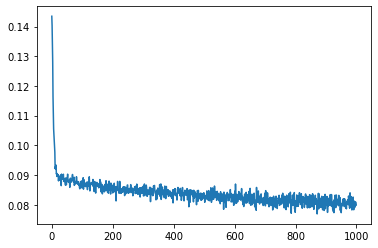

----========= CYCLE 2/20 - 40000 iterations =========----


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

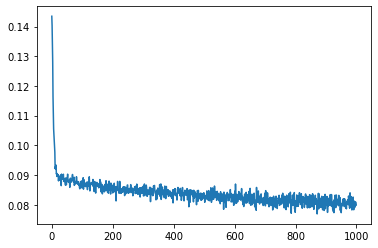

In [12]:
from datetime import datetime
from math import ceil
import os

ITERS = 20000
EPOCHS = 20
SAVE_MODEL_EVERY = 1
SAVE_PLOT_EVERY = 1
PLOT_TIMES = 1000
PRINT_TIMES = 5
BATCH_PRINT_SIZE = 5

test_input = pairs[0][0]

start_time = str(datetime.now().strftime("%d.%m_%H.%M"))
output_file = f"output/out-{start_time}.txt"
# output_file = "output/out-23.08_01.18.txt"

with open(output_file, 'w', encoding='utf-8') as outfile:
  pass

for epoch in range(done_epochs, EPOCHS):
  losses = [-1]

  with open(output_file, 'a', encoding='utf-8') as outfile:
    print(f"----========= CYCLE {epoch+1}/{EPOCHS} - {ITERS*(epoch+1)} iterations =========----")

    plot = trainIters(encoder, decoder, ITERS, print_every=ceil(ITERS/PRINT_TIMES), plot_every=ceil(ITERS/PLOT_TIMES))
    outputs, _ = evaluate(encoder, decoder, test_input)

    now = datetime.now().strftime("%d.%m_%H.%M")
    
    outfile.write(f"\n----========= CYCLE {epoch+1}/{EPOCHS} - {ITERS*(epoch+1)} iterations =========----\n\n")
  
    for i in range(min(BATCH_PRINT_SIZE, len(outputs))):
      outfile.write("----------------------\n")
      predict = ""
      target = ""
      for word in outputs[i]:
        predict += str(word) + " "
      outfile.write(predict + "\n")
      outfile.write("-.... ↑|predict|↑ ....... ↓|target|↓ ....-\n")
      for word in pairs[0][1][i]:
        target += token_vocab.getWord(word.item()) + " "
      outfile.write(target + "\n")

  if epoch % SAVE_PLOT_EVERY == 0:
    plot.savefig(f"plots/plot-{now}-{(epoch+1)*ITERS}-iters.png", facecolor ='orange')

  if epoch % SAVE_MODEL_EVERY == 0:
    torch.save(encoder, f"saved_models/encoder_{now}-{(epoch+1)*ITERS}-iters.pt")
    torch.save(decoder, f"saved_models/decoder_{now}-{(epoch+1)*ITERS}-iters.pt")

# os.system('shutdown -s')  

In [ ]:
encoder = torch.load("saved_models/encoder_100000-iters.pt")
decoder = torch.load("saved_models/decoder_100000-iters.pt")

test_input = pairs[0][0]

outputs, _ = evaluate(encoder, decoder, test_input)
for i in range(len(outputs)):
  print("----------------------")
  predict = ""
  target = ""
  for word in outputs[i]:
    predict += str(word) + " "
  print(predict)
  print("-.... ↑|predict|↑ ....... ↓|target|↓ ....-")
  for word in pairs[0][1][i]:
    target += token_vocab.getWord(word.item()) + " "
  print(target)
